In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import iqr

In [ ]:
def normalized_dist_rank(rank, len_1, len_2):
  bigger_len = len_1 if len_1 >= len_2 else len_2
  smaller_len = len_2 if len_1 >= len_2 else len_1
  max_rank = 2 * sum([i for i in range(bigger_len - smaller_len + 1, bigger_len - 1, 2)])
  return rank/max_rank

In [ ]:
def dameraulevenshtein(s1, s2):
    d = {}
    lenstr1 = len(s1)
    lenstr2 = len(s2)
    for i in range(-1,lenstr1+1):
        d[(i,-1)] = i+1
    for j in range(-1,lenstr2+1):
        d[(-1,j)] = j+1

    for i in range(lenstr1):
        for j in range(lenstr2):
            if s1[i] == s2[j]:
                cost = 0
            else:
                cost = 1
            d[(i,j)] = min(
                           d[(i-1,j)] + 1, # deletion
                           d[(i,j-1)] + 1, # insertion
                           d[(i-1,j-1)] + cost, # substitution
                          )
            if i and j and s1[i]==s2[j-1] and s1[i-1] == s2[j]:
                d[(i,j)] = min (d[(i,j)], d[i-2,j-2] + cost) # transposition
    return d[lenstr1-1,lenstr2-1] 

In [ ]:
def normalized_lev(lev, n):
  return lev/n

In [ ]:
def DRL(normalized_levenshtein, normalized_rank):
  return ((normalized_levenshtein + normalized_rank)/2)

In [ ]:
def megazord_metric(input_counters_1, input_counters_2):
  '''
    Gets lists of n-grams, sorted by rank. Returns F-statistics for two idioms.
    Params: 
      input_counters_1: a list of tuples in form (n-gram, rank) for lect 1.
      input_counters_2: a list of tuples in form (n-gram, rank) for lect 2.
    Returns:
      Fst: float, F-statistics for two idioms
  '''
  n = max([len(n[0]) for m in [input_counters_1, input_counters_2] for n in m])
  all_n_grams = []
  in_l1_not_in_l2 = [i for i in input_counters_1 if i[0] not in [j[0] for j in input_counters_2]]
  in_l2_not_in_l1 = [i for i in input_counters_2 if i[0] not in [j[0] for j in input_counters_1]]
  for i in in_l1_not_in_l2:
    min_lev = min([dameraulevenshtein(i[0], j[0]) for j in in_l2_not_in_l1])
    min_by_lev = [j for j in in_l2_not_in_l1 if dameraulevenshtein(i[0], j[0]) == min_lev]
    min_dist_rank = min([abs(i[1] - j[1]) for j in min_by_lev])
    all_n_grams.append((i[0], DRL(normalized_lev(min_lev, n),  normalized_dist_rank(min_dist_rank, len(input_counters_1), len(input_counters_2)))))
  for i in in_l2_not_in_l1:
    min_lev = min([dameraulevenshtein(i[0], j[0]) for j in in_l1_not_in_l2])
    min_by_lev = [j for j in in_l1_not_in_l2 if dameraulevenshtein(i[0], j[0]) == min_lev]
    min_dist_rank = min([abs(i[1] - j[1]) for j in min_by_lev])
    all_n_grams.append((i[0], DRL(normalized_lev(min_lev, n),  normalized_dist_rank(min_dist_rank, len(input_counters_1), len(input_counters_2)))))
  common_l1 = [i for i in input_counters_1 if i not in in_l1_not_in_l2]
  common_l2 = [i for i in input_counters_2 if i not in in_l2_not_in_l1]
  for i in common_l1:
    dist_rank = 0
    for j in common_l2:
      if (i[0] == j[0]):
        dist_rank = normalized_dist_rank(abs(i[1] - j[1]), len(input_counters_1), len(input_counters_2)) # splitting by two for normalization with aa; check later
        all_n_grams.append((i[0], dist_rank))
        all_n_grams.append((j[0], dist_rank))
        break
  Q1, Q3 = np.percentile([i[1] for i in all_n_grams], [25, 75])
  IQR = iqr([i[1] for i in all_n_grams])
  outlier_rim_low = Q1 - 1.5 * IQR
  outlier_rim_high = Q3 + 1.5 * IQR
  AA = [i for i in all_n_grams if i[1] <= outlier_rim_low]
  Aa = [i for i in all_n_grams if ((i[1] > outlier_rim_low) and (i[1] < outlier_rim_high))]
  aa = [i for i in all_n_grams if i[1] >= outlier_rim_high]
  overall_length = len(input_counters_1) + len(input_counters_2)
  AA_rel = len(AA)/overall_length
  Aa_rel = len(Aa)/overall_length
  aa_rel = len(aa)/overall_length
  print(AA_rel)
  print(Aa_rel)
  print(aa_rel)
  A = AA_rel + 0.5 * Aa_rel
  a = aa_rel + 0.5 * Aa_rel 
  equilibrium = 2 * A * a
  Fst = (equilibrium - Aa_rel)/equilibrium
  return Fst

In [ ]:
a = [("a", 1), ("ab", 2), ("aa", 3), ("b", 4)]
b = [("a", 1), ("aa", 2), ("c", 3)]
F = megazord_metric(a, b)
print(F)

0.0
1.0
0.0
-1.0


[0.44135697 0.05261868 0.70749603 0.88518035 0.26333887 0.21792654
 0.4213641  0.33238567 0.33453825 0.43661761 0.95093277 0.0075572
 0.49186193 0.15909533 0.74075532 0.42598529 0.18347399 0.96982341
 0.4207636  0.22133736 0.1826538  0.51891226 0.24062257 0.36739198
 0.02222401 0.64588367 0.9658414  0.07052937 0.81006778 0.70559312
 0.49121403 0.6065561  0.95507    0.0103371  0.45012983 0.191431
 0.67381899 0.7417409  0.79281095 0.85549513 0.6380242  0.9956946
 0.35243267 0.84989985 0.40343972 0.66941628 0.42364168 0.75675527
 0.41117196 0.94929255 0.1992902  0.27735245 0.44895834 0.95865149
 0.86940388 0.07705201 0.90213102 0.98798747 0.59437644 0.64681877
 0.83041064 0.90246403 0.04166393 0.06759162 0.60210618 0.28930031
 0.26196011 0.46691886 0.80422487 0.50316173 0.10398047 0.9296635
 0.61081026 0.83144806 0.14971785 0.05368508 0.55410363 0.5975912
 0.82340143 0.68096118 0.70071421 0.29710209 0.37944424 0.3057956
 0.13098967 0.17459481 0.02141498 0.25435731 0.42359347 0.96182123
 0

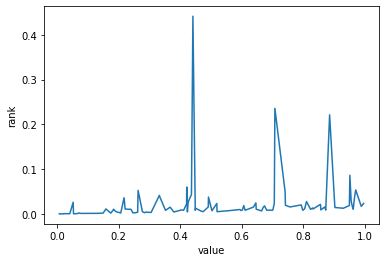

In [ ]:
generated = np.random.rand(100)
print(generated)
ranks = [generated[i - 1]/i for i in range(1, len(generated) + 1)]
order = list(zip(generated, ranks))
df = pd.DataFrame(order, columns=['value', 'rank'])
sns.lineplot(x='value', y='rank', data=df)

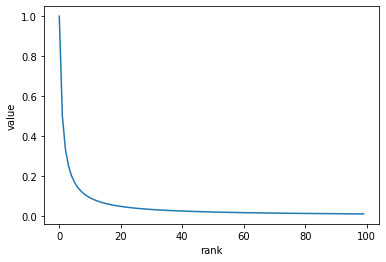

In [ ]:
generated = np.ones(100)
ranks = [generated[i - 1]/i for i in range(1, len(generated) + 1)]
order = list(zip(range(len(generated) + 1), ranks))
df = pd.DataFrame(order, columns=['rank', 'value'])
sns.lineplot(x='rank', y='value', data=df)

In [ ]:
# AA = n-граммы, характерные для 1 идиома
# Aa = n-граммы, характерные для обоих идиомов
# aa = n-граммы, характерные для 2 идиома

In [ ]:
def megazord_viz(input_counters_1, input_counters_2):
  n = max([len(n[0]) for m in [input_counters_1, input_counters_2] for n in m])
  all_n_grams = []
  counter = 0
  for i in input_counters_1:
    all_n_grams.append([])
    for j in input_counters_2:      
      lev = normalized_lev(dameraulevenshtein(i[0], j[0]), n)
      dist_rank = normalized_dist_rank(abs(i[1] - j[1]), len(input_counters_1), len(input_counters_2))
      drl = DRL(lev, dist_rank)
      all_n_grams[counter].append(drl)
    counter = counter + 1
  sns.heatmap(all_n_grams, xticklabels=[i[0] for i in input_counters_2], yticklabels=[i[0] for i in input_counters_1])

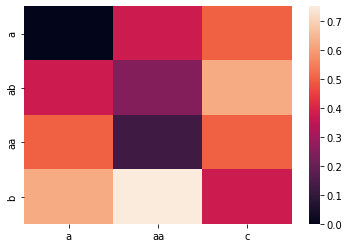

In [ ]:
megazord_viz(a, b)